## Load modules

In [136]:
import numpy as np
import imp
import ens_snapshot_tools as ens
import matplotlib.pyplot as plt

# for debugging
imp.reload(ens)

# Luke's
import utils #utils file with functions
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import stats
from scipy import signal
import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm

import utils

## K-L divergence calculations for multiple binsizes

In [ ]:
imp.reload(ens)
# Run klcomp(binsize)
binsizevec = [1]
for binsize in binsizevec:
    tC, kld, tCc, kldc = ens.klcomp_samebasis_reg(binsize)
    plt.plot(tCc,kldc)
    plt.axhline(np.mean(kldc)+2*np.std(kldc),c='k',linewidth=.5)
    plt.axhline(np.mean(kldc)-2*np.std(kldc),c='k',linewidth=.5)
    plt.title('Baseline control K-L divergence about control mean')
    plt.show()
    plt.plot(tC,kld,label='All-Forcing')
    plt.axhline(np.mean(kldc)+2*np.std(kldc),c='k',linewidth=.5,label=r'2\sigma')
    plt.axhline(np.mean(kldc)-2*np.std(kldc),c='k',linewidth=.5)
    plt.title('LME K-L divergence about control mean, binsize = '+ str(binsize))
    plt.show()
    
    print(np.median(kld)-np.median(kldc))
    
    #plt.hist(kldc-np.mean(kldc),density=True,bins=np.arange(110,145,1));
    #plt.hist(kld-np.mean(kld),density=True,bins=np.arange(110,145,1),alpha=.5);
    plt.hist(kldc-np.median(kldc),density=True,bins=np.arange(-5,100,1));
    plt.hist(kld-np.median(kld),density=True,bins=np.arange(-5,100,1),alpha=.5);
    plt.legend(['Control','LME'])
    plt.title('K-L divergence about control mean, binsize = '+ str(binsize))
    plt.show()

In [93]:

# for debugging
imp.reload(ens)

binsize = 1

nens = 13
nEOF = 500
reg = 1

# Now for LME

out = np.load('input/CESM_LME_all13_wtd_SVD.npz')
uLME    = out['u']
sLME    = out['s']
vtLME   = out['vt']
lat  = out['lat']
lon  = out['lon']
time = out['time']
nt   = out['nt']
nlat = out['nlat']
nlon = out['nlon']
nens = out['nens']

# EOF x time*nens
datr = (vtLME[:nEOF,:]*sLME[:nEOF,None])

# reshaped into timexEOFxnens
datrr = datr.reshape(nEOF,nt,nens).transpose(1,0,2)

# Get time-varying reduced-space covariances
[C,tC,m]        = ens.mk_covs(datrr,time,binsize)
[td,_,_]      = C.shape
Cv            = C.reshape(td,nEOF**2).T

#### Load ctrl run

out = np.load('input/CESM_ctrl_wtd_SVD.npz')
u    = out['u']
s    = out['s']
vt   = out['vt']
lat  = out['lat']
lon  = out['lon']
time = out['time']
nt   = out['nt']
nlat = out['nlat']
nlon = out['nlon']

ds_TS = u.dot(np.diag(s)).dot(vt).reshape(1000,nlat,nlon)

[nt,nlat,nlon] = np.shape(ds_TS);

# Reshape the control run to look like a short ensemble simulation with 13 members
# New time length for these is 988 = 13*76
cnens = 13;
tdn   = int(np.floor(1000./cnens)*cnens)
el    = int(tdn/cnens)

# Reshape to give an ensemble axis and transpose to make the ordering consistent
ce1 = ds_TS[:(tdn),:,:].reshape(tdn,nlat*nlon).transpose([1,0])
ce2 = ce1.reshape(nlat*nlon,el,cnens)

# time, space, nens
ce  = ce2.transpose([1,0,2])

# Need to compute reduced-space form
# pdb.set_trace()
cer  = ens.reduce_space_proj(ce,uLME[:,:nEOF])

[Cc,tCc,mc]       = ens.mk_covs(cer,np.arange(el),binsize)
[tdc,_,_]      = Cc.shape
Cvc            = Cc.reshape(tdc,nEOF**2).T

# No smoothing for mean
#[Ccm,tCcm,mc]       = ens.mk_covs(cer,np.arange(el),1)
#[tdcm,_,_]       = Ccm.shape
#Cvcm             = Ccm.reshape(tdcm,nEOF**2).T
# Cmc = Cvcm.mean(axis=1, keepdims=True).reshape(nEOF,nEOF)

Cmc,mmc = ens.mk_avg_cov(cer)

#m0 = m
#m1 = mmc

m0 = np.zeros(nEOF)
m1 = np.zeros(nEOF)

In [106]:
### Compute kld for control and LME

kldc = np.empty(tdc)
for ii in np.arange(tdc):
    kldc[ii] = ens.KLdiv(Cc[ii,:,:]+reg*np.eye(nEOF),Cmc+reg*np.eye(nEOF),m0,m1)


kld = np.empty(td)
for ii in np.arange(td):
    kld[ii] = ens.KLdiv(C[ii,:,:]+reg*np.eye(nEOF),Cmc+reg*np.eye(nEOF),m0,m1)


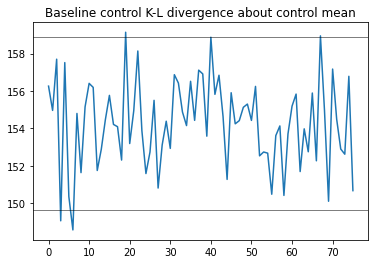

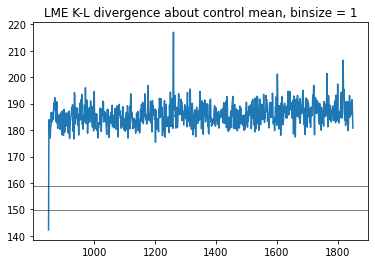

31.15519174077454


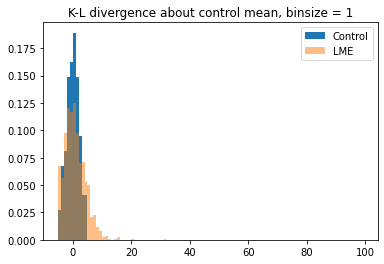

In [107]:
    plt.plot(tCc,kldc)
    plt.axhline(np.mean(kldc)+2*np.std(kldc),c='k',linewidth=.5)
    plt.axhline(np.mean(kldc)-2*np.std(kldc),c='k',linewidth=.5)
    plt.title('Baseline control K-L divergence about control mean')
    plt.show()
    plt.plot(tC,kld,label='All-Forcing')
    plt.axhline(np.mean(kldc)+2*np.std(kldc),c='k',linewidth=.5,label=r'2\sigma')
    plt.axhline(np.mean(kldc)-2*np.std(kldc),c='k',linewidth=.5)
    plt.title('LME K-L divergence about control mean, binsize = '+ str(binsize))
    plt.show()
    
    print(np.median(kld)-np.median(kldc))
    
    #plt.hist(kldc-np.mean(kldc),density=True,bins=np.arange(110,145,1));
    #plt.hist(kld-np.mean(kld),density=True,bins=np.arange(110,145,1),alpha=.5);
    plt.hist(kldc-np.median(kldc),density=True,bins=np.arange(-5,100,1));
    plt.hist(kld-np.median(kld),density=True,bins=np.arange(-5,100,1),alpha=.5);
    plt.legend(['Control','LME'])
    plt.title('K-L divergence about control mean, binsize = '+ str(binsize))
    plt.show()

## Compute dominant changes to covariance

In [ ]:
# Remove the time mean covariance
Cnm           = Cv - Cv.mean(axis=0, keepdims=True)
[uC,sC,vCt]   = np.linalg.svd(Cnm, full_matrices=False)

# Plot this many PCs
pltn          = 40

plt.plot(tC,(vCt[:pltn,:]*sC[:pltn,None]).T)

# Plot EOFs of the leading nonstationarity matrix
[uu,ss,_]    = np.linalg.svd(uC[:,0].reshape(nEOF,nEOF),full_matrices=False)

map = u[:,:500].dot(uu[:,0])

plt.matshow(map.reshape([nlat,nlon]))

# Nontrivial to project back into physical space. Will give non-orthogonal patterns. Have to think more.


In [ ]:
plt.matshow(map.reshape([nlat,nlon]))

## Regression!

In [ ]:
#binsize = 1
nens = 13
nEOF = 500

# EOF x time*nens
datr = (vt[:nEOF,:]*s[:nEOF,None])

# reshaped into timexEOFxnens
datrr = datr.reshape(nEOF,nt,nens).transpose(1,0,2)

# Get time-varying reduced-space covariances
[C,tC]        = ens.mk_covs(datrr,time,binsize)
[td,_,_]      = C.shape
Cv            = C.reshape(td,nEOF**2).T

# No smoothing for mean
[Cm,tCm]        = ens.mk_covs(cer,np.arange(el),1)
[tdm,_,_]       = Ccm.shape
Cvm             = Ccm.reshape(tdcm,nEOF**2).T
Cm = Cvm.mean(axis=1, keepdims=True).reshape(nEOF,nEOF)

In [ ]:
reg = 1

m0 = np.zeros(nEOF)
m1 = np.zeros(nEOF)

kld = np.empty(td)
for ii in np.arange(td):
    kld[ii]   = ens.KLdiv(C[ii,:,:]+reg*np.eye(nEOF),Cmc+reg*np.eye(nEOF),m0,m1)

In [ ]:
# Regress forcing time series onto covariances to obtain patterns of non-stationarity associated with forcing
# Need to get time series of forcing amplitudes (global mean) to do this. I would hypothesize that if we remove the patterns associated with
# these regressions (maybe at some lag?) computed for all forcing time series then we'd get back variability that has K-L divergence indistinguishable from the control run!

# Load volcano forcing
out   = np.load('output/IVI2Loading_Annual.npz')
tvolc = out['time_annual']
volc  = out['MMRVOLC_ANN']

In [ ]:
# Shorten. This gives 849:1849, one year offset from KLD
OFF = 1
vs = volc[(350-OFF):(1350-OFF)]
tvs = tvolc[(350):(1350)]
plt.scatter(vs,kld)
plt.show()

plt.figure(figsize=(20,5))
kldn = (kld-np.mean(kld))/np.std(kld)
vsn = vs/np.std(vs)/3
plt.plot(tC[:-1],kldn[1:])
plt.plot(tvs,vsn)
plt.xlim(850,1850)

In [ ]:
# Normalize like a PC
vns = vs/np.linalg.norm(vs)

# Regression happens here
nC    = Cv.dot(vns)
# nC    = vns.T.dot(Cnm.T)
wt    = np.linalg.norm(nC)
print(wt)
nCr   = nC.reshape(nEOF,nEOF)

[uCr,sCr,vCr] = np.linalg.svd(nCr,full_matrices=False)

plt.plot(sCr[:10]**2/np.sum(sCr[:10]**2))
plt.show()

plt.matshow(np.flipud(u[:,:500].dot(uCr[0,:]).reshape(nlat,nlon))),plt.colorbar()

In [ ]:
# Do we get a stationary-like covariance if we remove this part?

Cres = Cv-nC.dot(vns.T)

In [ ]:
kldres = np.empty(td)
reg = 1
for ii in np.arange(td):
    kldres[ii]   = ens.KLdiv(Cres[:,ii].reshape(nEOF,nEOF)+reg*np.eye(nEOF),Cmc+reg*np.eye(nEOF),m0,m1)
    

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(tC,kldres)
plt.plot(tC,kld)
plt.ylim(0,300)